In [1]:
from model import eccv16
from dataset import MangaDataset

import torch
import torch.nn as nn

import torch.optim as optim

from skimage import color
from PIL import Image
import numpy as np

from torch.utils.tensorboard import SummaryWriter

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

mangaDataset = MangaDataset('../colorization-av-enseirb-2020/dataset/one_piece')

datasetLoader = torch.utils.data.DataLoader(mangaDataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

colorizer_eccv16 = eccv16(pretrained=True).eval().to(device)

writer = SummaryWriter()

In [6]:
EPOCHS = 30

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(colorizer_eccv16.parameters(), lr=3.16e-5, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.001)

In [8]:
for epoch in range(EPOCHS):
    total_running_loss = 0.0
    for i, batch in enumerate(datasetLoader, 0):

        ipt, target = batch
        
        ipt, target = ipt.to(device), target.to(device)
                
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = colorizer_eccv16(ipt)

        loss = criterion(target, outputs)
        loss.backward()
        optimizer.step()
        
        # print statistics
        total_running_loss += loss.item()
        #if i % 10 == 1:    # print every 2000 mini-batches
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 10.))
        #    running_loss = 0.0
    print("Avg", total_running_loss)
    writer.add_scalar('train_loss', total_running_loss, epoch)

/home/otavio/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Avg 1219.7526321411133
Avg 1077.7214660644531
Avg 995.1293487548828
Avg 936.3467864990234
Avg 883.3116302490234
Avg 834.7379608154297
Avg 789.9828186035156
Avg 739.1589660644531
Avg 714.9708557128906
Avg 676.19384765625
Avg 654.4509353637695
Avg 627.3839721679688
Avg 611.5749816894531
Avg 595.3569793701172
Avg 576.5688705444336
Avg 564.8370513916016
Avg 548.2544174194336
Avg 536.033447265625
Avg 530.6741638183594
Avg 516.7049026489258
Avg 525.453987121582
Avg 504.8412628173828
Avg 489.45348358154297
Avg 470.62512969970703
Avg 459.841854095459
Avg 455.13829803466797
Avg 443.68738555908203
Avg 433.55533599853516
Avg 422.7821502685547
Avg 414.90796661376953


In [16]:
batch = next(iter(datasetLoader))
ipt, target = batch
ipt, target = ipt.to('cpu'), target.to('cpu')

In [18]:
cpu_model = colorizer_eccv16.to('cpu')

/home/otavio/anaconda3/lib/python3.8/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


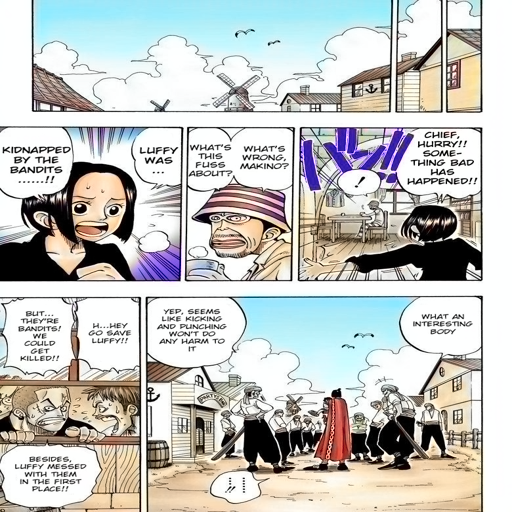

In [25]:
y_pred = cpu_model(ipt)
out_lab_orig = torch.cat((ipt, y_pred), dim=1)

o=color.lab2rgb(out_lab_orig[2].unsqueeze(0).data.cpu().numpy()[0,...].transpose((1,2,0)))
im = Image.fromarray(np.uint8(o*255))

im

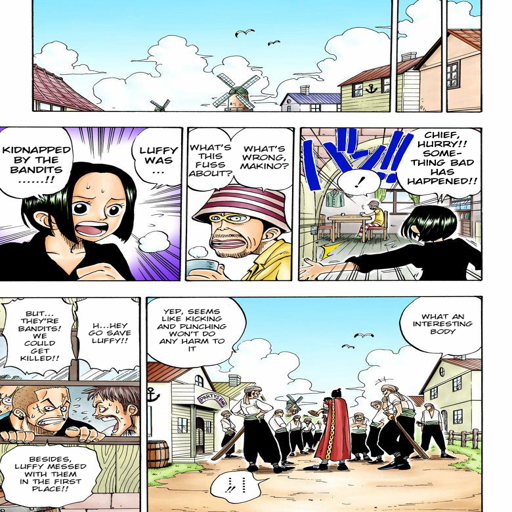

In [26]:
out_lab_orig = torch.cat((ipt, target), dim=1)
o=color.lab2rgb(out_lab_orig[2].unsqueeze(0).data.cpu().numpy()[0,...].transpose((1,2,0)))
im = Image.fromarray(np.uint8(o*255))
im

In [41]:
# For the real manga.... It will be harder than that :)

out_np = np.asarray(Image.open('./dataset/one_piece/bw/chapter_1_1.png').resize((512,512), resample=3))
img_l_orig = color.rgb2lab(out_np)[:,:,0]
tens_orig_l = torch.Tensor(img_l_orig).unsqueeze(0).unsqueeze(0)

y_pred = cpu_model(tens_orig_l)
out_lab_orig = torch.cat((tens_orig_l, y_pred), dim=1)

o=color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
im = Image.fromarray(np.uint8(o*255))